In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


In [4]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/archive  CFD/haarcascade_frontalface_default.xml')

Function for getting cropped faces from an image

In [5]:
# returns an array if the image contains more than one faces
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    roi=[]
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            roi.append(roi_color)
    return roi

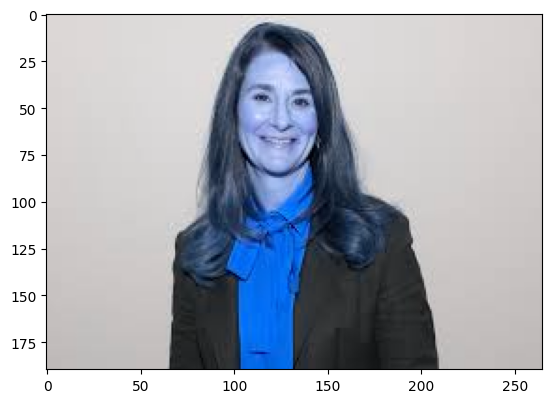

In [6]:
# reading an image
x='/content/drive/MyDrive/archive  CFD/Dataset/Dataset/Melinda_Gates/2Q__ (10).jpg'
original_image=cv2.imread(x)
plt.imshow(original_image)

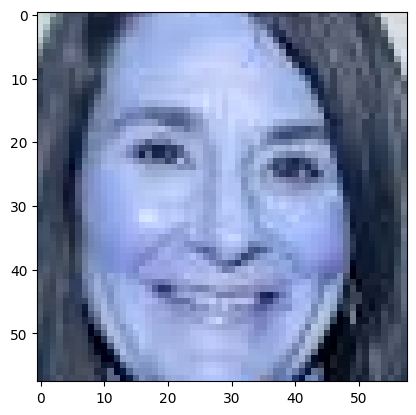

In [7]:
#cropping the face from the image

cropped_image=get_cropped_image_if_2_eyes(x)
for i in range(len(cropped_image)):
    plt.imshow(cropped_image[i])


2.Load and Manipulate Data

In [8]:
path_to_data = "/content/drive/MyDrive/archive  CFD/Dataset/Dataset"
path_to_cr_data = "/content/drive/MyDrive/archive  CFD/cropped/cropped"

In [9]:
# dataset folder contains folders of different personalities which are containing raw images
import os
img_dirs = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['/content/drive/MyDrive/archive  CFD/cropped/cropped/Vikas_Khanna',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Virat_Kohli',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Narendra_Modi',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Barack_Obama',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Dalai_Lama',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Melinda_Gates',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Sundar_Pichai',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Indira_Nooyi',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Bill_Gates',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Anushka_Sharma']

In [10]:
img_dirs

['/content/drive/MyDrive/archive  CFD/cropped/cropped/Vikas_Khanna',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Virat_Kohli',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Narendra_Modi',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Barack_Obama',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Dalai_Lama',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Melinda_Gates',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Sundar_Pichai',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Indira_Nooyi',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Bill_Gates',
 '/content/drive/MyDrive/archive  CFD/cropped/cropped/Anushka_Sharma']

3. Data Preparation for the Model fitting

In [11]:
# Generating wavelet images for fitting into SVM and Logistic Regression models.

import numpy as np
import pywt
import cv2

def w2d(img,mode='haar',level=1):
    imArray=img
    #Data-type conversion
    #convert to grayscale
    imArray=cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray=np.float32(imArray)
    imArray/=255
    #computeCoefficients
    coeffs=pywt.wavedec2(imArray,mode,level=level)

    #process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0

    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)

    return imArray_H

Storing cropped images names in a dictionary

In [12]:
celebrity_file_names_dict2={}
for img_dir in img_dirs:
#     print(img_dir)
    celebrity_name = img_dir.split('/')[-1]
#     print(celebrity_name)
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict2[celebrity_name] = file_list
# celebrity_file_names_dict2

Dictionary to store classes of different personalities.


In [13]:
class_dict2 = {}
count = 0
for celebrity_name in celebrity_file_names_dict2.keys():
    class_dict2[celebrity_name] = count
    count = count + 1
class_dict2

{'Vikas_Khanna': 0,
 'Virat_Kohli': 1,
 'Narendra_Modi': 2,
 'Barack_Obama': 3,
 'Dalai_Lama': 4,
 'Melinda_Gates': 5,
 'Sundar_Pichai': 6,
 'Indira_Nooyi': 7,
 'Bill_Gates': 8,
 'Anushka_Sharma': 9}

In [14]:
# inverse dictionary
inv_dict2 = dict(zip(class_dict2.values(), class_dict2.keys()))
inv_dict2

{0: 'Vikas_Khanna',
 1: 'Virat_Kohli',
 2: 'Narendra_Modi',
 3: 'Barack_Obama',
 4: 'Dalai_Lama',
 5: 'Melinda_Gates',
 6: 'Sundar_Pichai',
 7: 'Indira_Nooyi',
 8: 'Bill_Gates',
 9: 'Anushka_Sharma'}

Creating a vertical stack of raw image and wavelet function generated image and storing in input variable X

In [15]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict2.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is not None:
            scalled_raw_img = cv2.resize(img, (32, 32))
            img_har = w2d(img,'db1',5)
            scalled_img_har = cv2.resize(img_har, (32, 32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
            X.append(combined_img)
            y.append(class_dict2[celebrity_name])

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [16]:
# we have total 2716 images to fit into model
len(X)

2725

In [17]:
# reshaping to 32*32*2 size
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(2725, 4096)

4. Model fitting and selection

In [18]:
# fitting into SVM classfier with rbf kernel
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9134897360703812

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        65
           1       0.96      0.93      0.95        75
           2       0.96      0.95      0.96        58
           3       0.88      0.94      0.91        96
           4       0.84      0.84      0.84        51
           5       0.95      0.98      0.96        92
           6       0.95      0.92      0.94        65
           7       0.94      0.84      0.89        61
           8       0.91      0.91      0.91        57
           9       0.86      0.87      0.86        62

    accuracy                           0.91       682
   macro avg       0.91      0.91      0.91       682
weighted avg       0.91      0.91      0.91       682



Using GridSearchCV to generate the best model

In [20]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100],
            'svc__kernel': ['rbf','linear']
        }
    },

    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [23]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.879098,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,logistic_regression,0.850212,{'logisticregression__C': 1}


In [24]:
best_estimators['svm'].score(X_test,y_test)

0.8958944281524927

In [25]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8475073313782991

Best Model till now is SVM with 91% test data accuracy

In [26]:
best_clf = best_estimators['svm']

In [27]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma='auto', kernel='linear', probability=True))])

In [28]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        65
           1       0.99      0.95      0.97        75
           2       0.92      0.97      0.94        58
           3       0.87      0.89      0.88        96
           4       0.84      0.82      0.83        51
           5       0.93      0.95      0.94        92
           6       0.94      0.89      0.91        65
           7       0.95      0.89      0.92        61
           8       0.88      0.89      0.89        57
           9       0.82      0.79      0.80        62

    accuracy                           0.90       682
   macro avg       0.89      0.89      0.89       682
weighted avg       0.90      0.90      0.90       682



Plotting the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[58,  1,  0,  1,  1,  0,  0,  1,  1,  2],
       [ 2, 71,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0, 56,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  3, 85,  1,  1,  1,  1,  1,  3],
       [ 0,  0,  0,  1, 42,  2,  1,  1,  3,  1],
       [ 1,  0,  0,  0,  1, 87,  0,  0,  1,  2],
       [ 0,  0,  0,  6,  0,  0, 58,  0,  0,  1],
       [ 4,  0,  0,  1,  0,  0,  0, 54,  0,  2],
       [ 0,  0,  2,  2,  2,  0,  0,  0, 51,  0],
       [ 5,  0,  0,  1,  2,  4,  0,  0,  1, 49]])

Text(95.72222222222221, 0.5, 'Truth')

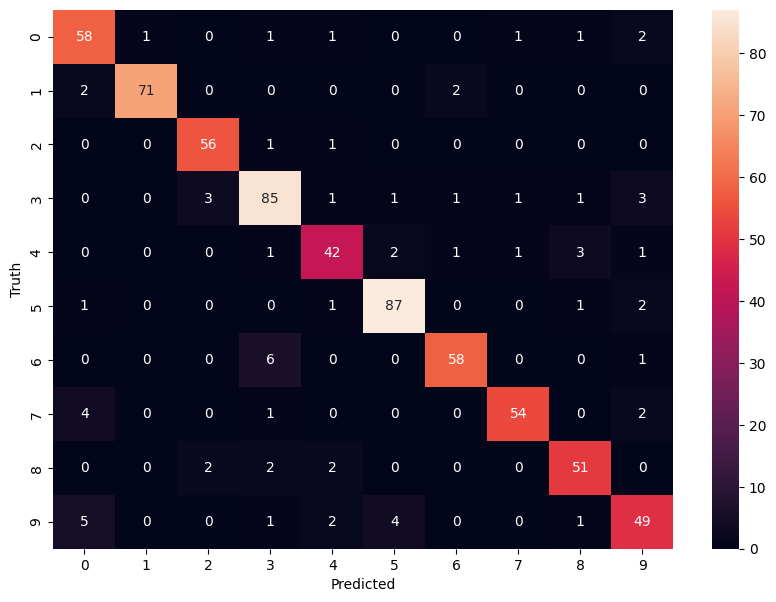

In [30]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Classifying using Convolutional Neural Networks(CNN)

In [31]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict2.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
#         if img is not None:
        scalled_raw_img = cv2.resize(img, (32, 32))
#         img_har = w2d(img,'db1',5)
#         scalled_img_har = cv2.resize(img_har, (32, 32))
#         combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(scalled_raw_img)
        y.append(class_dict2[celebrity_name])

In [32]:
len(X)

2725

array([[[ 20,  18,   7],
        [ 20,  19,   5],
        [ 24,  28,  13],
        ...,
        [ 39,  17,  13],
        [ 48,  22,  12],
        [ 80,  48,  35]],

       [[ 15,  15,   9],
        [ 21,  24,  16],
        [ 25,  32,  21],
        ...,
        [ 33,  14,  13],
        [ 41,  18,  12],
        [ 69,  40,  31]],

       [[ 11,  14,  12],
        [ 22,  27,  26],
        [ 22,  29,  28],
        ...,
        [ 27,  14,  16],
        [ 35,  19,  16],
        [ 53,  33,  25]],

       ...,

       [[ 22,  20,  27],
        [ 59,  71,  93],
        [ 69,  88, 125],
        ...,
        [111,  66,  32],
        [115,  70,  34],
        [118,  70,  34]],

       [[ 15,  15,  22],
        [ 30,  41,  64],
        [ 87, 104, 138],
        ...,
        [116,  70,  37],
        [120,  73,  37],
        [120,  71,  33]],

       [[ 14,  14,  21],
        [ 34,  43,  64],
        [ 81,  97, 127],
        ...,
        [121,  74,  40],
        [125,  75,  39],
        [122,  70,  33]]], dtype=uint8)
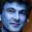

In [33]:
X[0]

In [34]:
len(X[0])

32

Changing shape of the input variable array to fit for CNN which requires 4 dimensional array

In [35]:
X = np.array(X).reshape(len(X),32,32,3).astype(float)
X.shape

(2725, 32, 32, 3)

In [36]:
y = np.array(y).reshape(-1).astype(float)
y.shape

(2725,)

In [37]:
X=X/255.0
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

Fitting data on CNN model

In [38]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.fit(X_train, y_train, epochs=40)

Epoch 1/40
69/69 [==============================] - 5s 32ms/step - loss: 2.2328 - accuracy: 0.1839
Epoch 2/40
69/69 [==============================] - 2s 33ms/step - loss: 1.6426 - accuracy: 0.4569
Epoch 3/40
69/69 [==============================] - 2s 33ms/step - loss: 0.9266 - accuracy: 0.7179
Epoch 4/40
69/69 [==============================] - 2s 33ms/step - loss: 0.5880 - accuracy: 0.8280
Epoch 5/40
69/69 [==============================] - 4s 58ms/step - loss: 0.4548 - accuracy: 0.8679
Epoch 6/40
69/69 [==============================] - 3s 38ms/step - loss: 0.3771 - accuracy: 0.8977
Epoch 7/40
69/69 [==============================] - 2s 32ms/step - loss: 0.3106 - accuracy: 0.9193
Epoch 8/40
69/69 [==============================] - 2s 33ms/step - loss: 0.3106 - accuracy: 0.9087
Epoch 9/40
69/69 [==============================] - 2s 33ms/step - loss: 0.1984 - accuracy: 0.9491
Epoch 10/40
69/69 [==============================] - 3s 42ms/step - loss: 0.1910 - accuracy: 0.9472
Epoch 11/

In [39]:
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

18/18 [==============================] - 0s 17ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        53
         1.0       1.00      0.95      0.97        61
         2.0       0.90      1.00      0.95        47
         3.0       0.95      0.95      0.95        75
         4.0       0.92      0.88      0.90        40
         5.0       0.91      0.97      0.94        77
         6.0       0.94      0.96      0.95        51
         7.0       0.98      0.92      0.95        53
         8.0       0.89      0.82      0.86        40
         9.0       0.86      0.88      0.87        48

    accuracy                           0.93       545
   macro avg       0.93      0.93      0.93       545
weighted avg       0.93      0.93      0.93       545



We can see that test data accuracy using CNN is coming to be 94% which is highest among all our models.Hence finalizing this as the final model for our image classification